# Regresión I: ¿Donde estan los ojos?

Muchos de los sistemas de reconocimiento de personas por medio de imagenes utilizan la ubicación de puntos importantes en la cara, con el objetivo de identificar la ubicación del rostro. Algunos puntos importantes son los ojos, la nariz y la boca, a partir de ellos es posible definir las coordenadas entre las cuales se encuentra ubicada la cara de la persona. El profesor Alexander siempre ha tenido una gran fascinadción por estos sistemas, y dado que sus estudiantes ya saben como trabajar con redes neuronales, él ha decidido que ellos realicen un sistemas de identificación de la ubicación de los ojos a partir de imagenes.

Para la realización de este proyecto el estudiante debera:

1. Crear una base de datos con fotografias donde diferentes personas, y en cada una de estas se debe generar un elemento que identifique la ubicación de los ojos. Aqui debe tener en cuenta dos cosas:
    * Tenga en cuenta que una red aprende con base en la información que le proporcionemos, asi que al crear la base de datos tenga en cuenta todas las posibilidades que se imaginen de como podrian estar esas fotos.
    * Si tenemos imagenes muy grandes esto requerira de una red muy grande que puede tardar mucho tiempo en entrenar. Tenga en cuenta esto por si es necesario procesar las imagenes antes de ingresarlas a la red.   
2. Definir las arquitecturas de red que debe probar.
3. Escoger la red que mejor se desempeñe.
4. Evaluar el rendimiento de la red.


Tenga en cuenta que todo el procedimiento debe ser lo mas amigable para probar. Es decir si el profesor Alexander quiere probar una foto, entonces él solo deberia ingresar la foto en una función la cual se encargue de hacer todo el procesamiento y proporcionar como salida si la persona tiene o no tapabocas.

Además el profesor quiere que contesten las siguientes preguntas:

1. ¿Qué puede concluir del comportamiento de la red y los datos proporcionados?
2. ¿Qué criterio utilizo para seleccionar la arquitectura de la red?
3. ¿Tiene la red el comportamiento esperado?, sino, ¿A qué cree que se debe esto?
4. ¿Qué le mejoraria al modelo que usted diseño?, ¿Cómo implementaría esas mejoras?

## Qué se debe entregar:

Par ala entrega del proyecto deben porporcionar:

1. La base de datos generada.
2. Un notebook de Jupyter donde presentan todo el pipeline para el entrenamiento de la red. Cada parte debe ser explicada.
3. El notebook debe incluir una función que permita ingresar una muestra de entrada y se proporcione la salida, sin mas pasos intermedios. Por lo tanto en esta función se debe tener en cuenta el acondicionamiento de los datos, antes de ser introducidos en la red neuronal par arealizar las predicciones.
4. El notebook debe incluir las respuestas a las preguntas planteadas.

In [22]:
import numpy as np
import pandas as pd
from random import randint
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, Convolution2D
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, RMSprop
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from sklearn.model_selection import train_test_split

In [23]:
face_images_db = np.moveaxis(np.load('face_images.npz')['face_images'], -1, 0)
face_images_db.shape


(7049, 96, 96)

In [24]:
landmarks = pd.read_csv('facial_keypoints.csv')
landmarks.shape



(7049, 30)

In [25]:
landmarks.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


In [26]:
prediction_fields = list(landmarks)[:4]
print('Columns for eye detection:\n', prediction_fields)

Columns for eye detection:
 ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y']


In [27]:
#Nomalizacion

Col_NtNan = landmarks['left_eye_center_x'].notna() 

for i in prediction_fields[1:]:
    Col_NtNan = Col_NtNan & landmarks[i].notna()


#print(type(Col_NtNan))

Col_NtNan = Col_NtNan.to_numpy() 

#print(type(Col_NtNan))

Sel_ar = np.nonzero(Col_NtNan)[0]
Sel_ar.shape


(7033,)

In [28]:
Y = np.zeros((Sel_ar.shape[0], len(prediction_fields)))
for i in range(len(prediction_fields)):
    Y[:, i] = landmarks[prediction_fields[i]][Sel_ar] / face_images_db.shape[1]
Y.shape

(7033, 4)

In [29]:
#NOMRMALIZACION

X = np.zeros((Sel_ar.shape[0], face_images_db.shape[1], face_images_db.shape[1], 1))
X[:, :, :, 0] = face_images_db[Sel_ar, :, :] / 255.0
X.shape

(7033, 96, 96, 1)

In [30]:
def get_coordinates(arr, scale = 96):
    x, y = [], []
    for i in range(len(arr)):
        if i % 2 == 0:
            x.append(arr[i] * scale)
        else:
            y.append(arr[i]* scale)
    return x, y

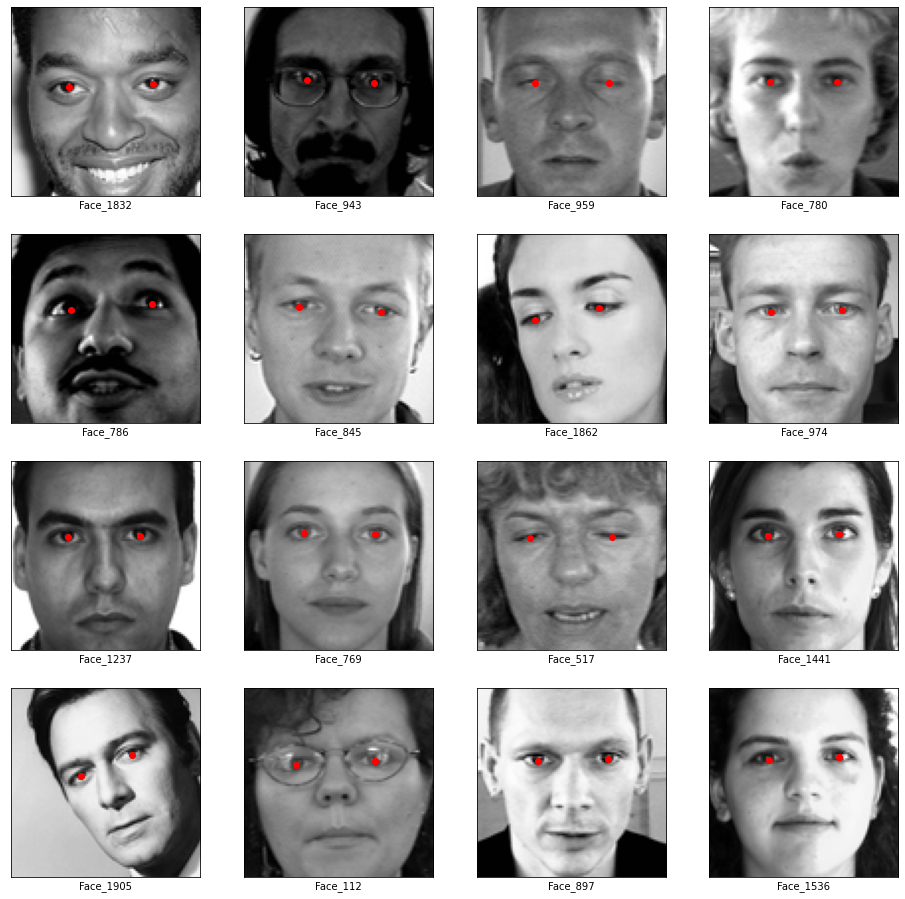

In [31]:
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (16, 16))
plt.setp(axes.flat, xticks = [], yticks = [])
for i, ax in enumerate(axes.flat):
    index = randint(0, 2167)
    img = X[index].reshape(96, 96)
    landmark_x, landmark_y = get_coordinates(Y[index])
    ax.imshow(img, cmap = 'gray')
    ax.scatter(landmark_x, landmark_y, c = 'r')
    ax.set_xlabel('Face_' + str(index))
plt.show()

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((6329, 96, 96, 1), (704, 96, 96, 1), (6329, 4), (704, 4))

In [33]:
model_1 = Sequential([
    Conv2D(16, (3, 3), padding = 'same', activation = 'tanh', input_shape = (96, 96, 1)),
    MaxPooling2D(2, 2),
    Dropout(rate = 0.75),
    Conv2D(32, (3, 3), padding = 'same', activation = 'tanh', input_shape = (96, 96, 1)),
    MaxPooling2D(2, 2),
    Dropout(rate = 0.75),
    Flatten(),
    Dense(256, activation = 'tanh'),
    Dropout(rate = 0.75),
    Dense(len(prediction_fields), activation = 'sigmoid')
])

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 96, 96, 16)        160       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)            

In [34]:
model_1.compile(
    loss = 'mean_squared_error',
    optimizer = SGD(
        learning_rate = 0.1,
        decay = 1e-6,
        momentum = 0.9,
        nesterov = True
    ),
    metrics = ['accuracy']
)

In [35]:
#NO FUNCIONA

#SVG(model_to_dot(model_1, show_shapes = True, show_layer_names = True).create(prog = 'dot', format = 'svg'))

In [36]:
history = model_1.fit(X_train, Y_train, batch_size = 128, epochs = 8, validation_data = (X_test, Y_test), verbose = 1)

Epoch 1/8
50/50 [==============================] - 34s 640ms/step - loss: 0.0214 - accuracy: 0.9338 - val_loss: 0.0131 - val_accuracy: 0.9943
Epoch 2/8
50/50 [==============================] - 32s 629ms/step - loss: 0.0032 - accuracy: 0.9957 - val_loss: 0.0067 - val_accuracy: 0.9943
Epoch 3/8
50/50 [==============================] - 32s 633ms/step - loss: 0.0024 - accuracy: 0.9957 - val_loss: 0.0040 - val_accuracy: 0.9943
Epoch 4/8
50/50 [==============================] - 32s 644ms/step - loss: 0.0020 - accuracy: 0.9957 - val_loss: 0.0025 - val_accuracy: 0.9943
Epoch 5/8
50/50 [==============================] - 32s 632ms/step - loss: 0.0018 - accuracy: 0.9957 - val_loss: 0.0025 - val_accuracy: 0.9943
Epoch 6/8
50/50 [==============================] - 31s 630ms/step - loss: 0.0017 - accuracy: 0.9957 - val_loss: 0.0017 - val_accuracy: 0.9943
Epoch 7/8
50/50 [==============================] - 32s 634ms/step - loss: 0.0016 - accuracy: 0.9956 - val_loss: 0.0017 - val_accuracy: 0.9943
Epoch 

In [37]:
model_1.evaluate(X_test, Y_test, verbose = 1)

22/22 [==============================] - 1s 38ms/step - loss: 0.0022 - accuracy: 0.9943


[0.0021532513201236725, 0.9943181872367859]

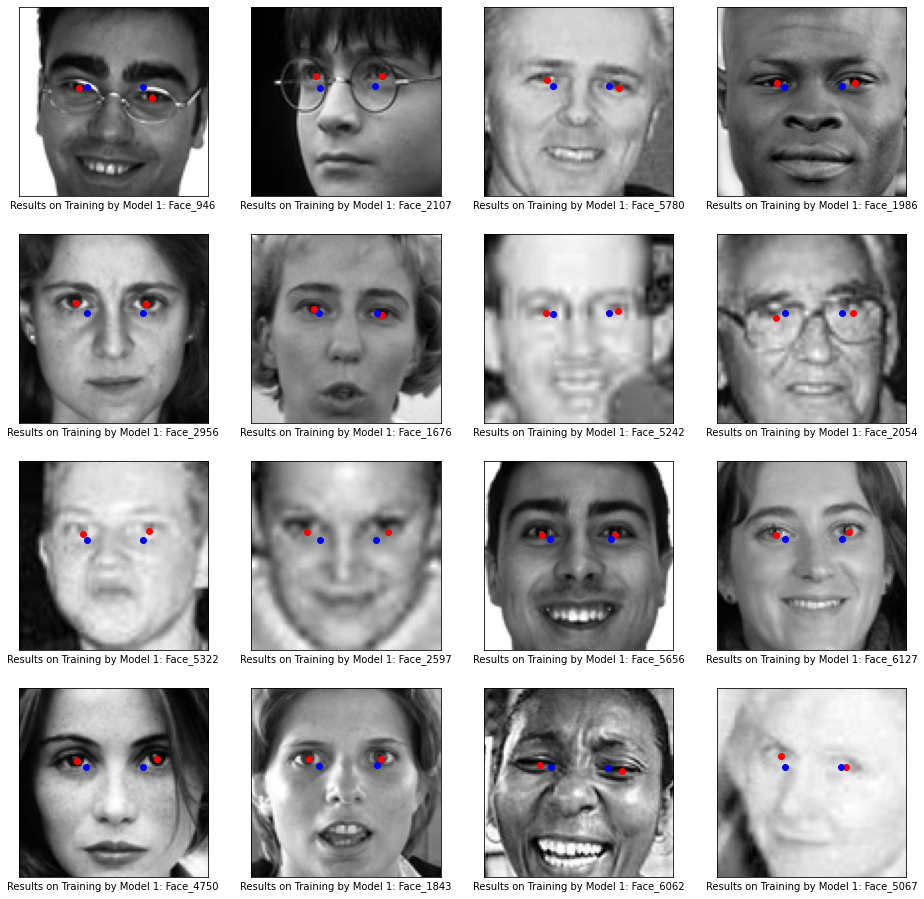

In [38]:
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (16, 16))
plt.setp(axes.flat, xticks = [], yticks = [])
for i, ax in enumerate(axes.flat):
    index = randint(0, 6329)
    img = X_train[index].reshape(96, 96)
    landmark_x_original, landmark_y_original = get_coordinates(Y_train[index])
    landmark_x, landmark_y = get_coordinates(model_1.predict(X_train[index].reshape(1, 96, 96, 1))[0])
    ax.imshow(img, cmap = 'gray')
    ax.scatter(landmark_x_original, landmark_y_original, c = 'r')
    ax.scatter(landmark_x, landmark_y, c = 'b')
    ax.set_xlabel('Results on Training by Model 1: Face_' + str(index))
plt.show()